In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 114.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="Enter_api_key")
project = rf.workspace("homework-stehh").project("minion-detection-ctmky")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Minion-detection-1 in yolov5pytorch:: 100%|██████████| 496/496 [00:00<00:00, 8416.57it/s]


In [3]:
import os
import cv2
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle


In [69]:
img_path = './Minion-detection-1/train/images'
lab_path = './Minion-detection-1/train/labels'
train_img_path = os.listdir(img_path)
train_lab_path = os.listdir(lab_path)

In [4]:
!pip install selectivesearch

  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4336 sha256=fbf45acae976ded8a3bf5a20d8f171e14ffa35faa98c84c596cf59b6749db0ad
  Stored in directory: /root/.cache/pip/wheels/7f/9b/c7/58b71f1e9fe4aa0ef8affd1c673f8818bc22a5091ea8cbbe93
Successfully built selectivesearch


In [70]:
import selectivesearch

In [71]:
def get_iou(bb1, bb2):
  top_x = max(bb1[0], bb2[0])
  top_y = max(bb1[1], bb2[1])
  bottom_x = min(bb1[0] + bb1[2], bb2[0] + bb2[2])
  bottom_y = min(bb1[1] + bb1[3], bb2[1] + bb2[3])
  if (top_x > bottom_x or top_y > bottom_y):
    return 0.0
  inter_area = float(bottom_x - top_x) * float(bottom_y - top_y)
  area1 = float(bb1[2] * bb1[3])
  area2 = float(bb2[2] * bb2[3])
  iou = inter_area / (area1 + area2 - inter_area)
  return iou

In [13]:
train_images = []
train_labels = []

for idx, label_path in enumerate(os.listdir(lab_path)):
  lines = []
  with open(os.path.join(lab_path, label_path), 'r') as f:
    lines = f.readlines()
  image = cv2.imread(os.path.join(img_path, label_path.replace(".txt", ".jpg")))
  img_lbl, rects = selectivesearch.selective_search(image, scale=200, sigma=0.9, min_size=10)
  img_h, img_w, img_d = image.shape
  counter = 0
  neg_counter = 0
  flag = False
  for ind, rect in enumerate(rects):
    box = rect['rect']
    if (box[2] <= 0 or box[3] <= 0):
      continue
    if (ind < 2000):
      for line in lines:
        id = float(line.split(" ")[0])
        c_x = float(line.split(" ")[1])
        c_y = float(line.split(" ")[2])
        w = float(line.split(" ")[3])
        h = float(line.split(" ")[4])
        c_x = c_x * img_w
        c_y = c_y * img_h
        w = w * img_w
        h = h * img_h
        x = c_x - (w / 2)
        y = c_y - (h / 2)
        p_x, p_y, p_w, p_h = box
        iou = get_iou(box, [x, y, w, h])
        if (iou >= 0.7):
          if (counter < 30):
            x1 = max(0, int(p_x))
            y1 = max(0, int(p_y))
            x2 = min(img_w, int(p_x + p_w))
            y2 = min(img_h, int(p_y + p_h))
            if (x1 > x2 or y1 > y2):
              continue
            timage = image[y1 : y2, x1 : x2]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            train_images.append(resized)
            train_labels.append(1)
            counter = counter + 1
        if (iou < 0.3):
          if (neg_counter < 30):
            x1 = max(0, int(p_x))
            y1 = max(0, int(p_y))
            x2 = min(img_w, int(p_x + p_w))
            y2 = min(img_h, int(p_y + p_h))
            if (x1 > x2 or y1 > y2):
              continue
            timage = image[y1 : y2, x1 : x2]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            train_images.append(resized)
            train_labels.append(0)
            neg_counter = neg_counter + 1
        if (counter >= 30 and neg_counter >= 30):
          flag = True
          break
      if (flag == True):
        break

In [14]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

with open('./drive/MyDrive/Colab Notebooks/train_data.pkl', 'wb') as f:
  pickle.dump((train_images, train_labels), f)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

train_images = []
train_labels = []
with open("./drive/MyDrive/Colab Notebooks/train_data.pkl", "rb") as f:
    train_images, train_labels = pickle.load(f)

In [17]:
from keras.layers import Dense
from keras import Model

vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output = x.output
y = Dense(1, 'sigmoid')(last_output)
model = Model(vgg.input, y)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


In [18]:
model.fit(train_images,train_labels,batch_size = 64,epochs = 3, verbose = 1,validation_split=.05,shuffle = True)

Epoch 1/3
101/101 ━━━━━━━━━━━━━━━━━━━━ 90s 636ms/step - accuracy: 0.9877 - loss: 0.3135 - val_accuracy: 1.0000 - val_loss: 4.0100e-22
Epoch 2/3
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 1.0000 - loss: 3.8771e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/3
101/101 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 1.0000 - loss: 1.4535e-40 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


In [19]:
model.save('./drive/MyDrive/Colab Notebooks/minion_vgg_model.h5')

In [72]:
model = keras.models.load_model('./drive/MyDrive/Colab Notebooks/minion_vgg_model.h5')

In [ ]:
svm_images = []
svm_labels = []
for idx, label_path in enumerate(os.listdir(lab_path)):
  lines = []
  with open(os.path.join(lab_path, label_path), 'r') as f:
    lines = f.readlines()
  image = cv2.imread(os.path.join(img_path, label_path.replace(".txt", ".jpg")))
  svm_images.append(cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA))
  svm_labels.append([0, 1])
  img_lbl, rects = selectivesearch.selective_search(image, scale=200, sigma=0.9, min_size=50)
  img_h, img_w, img_d = image.shape
  neg_counter = 0
  flag = False
  for ind, rect in enumerate(rects):
    box = rect['rect']
    if (ind < 200):
      for line in lines:
        id = float(line.split(" ")[0])
        c_x = float(line.split(" ")[1])
        c_y = float(line.split(" ")[2])
        w = float(line.split(" ")[3])
        h = float(line.split(" ")[4])
        c_x = c_x * img_w
        c_y = c_y * img_h
        w = w * img_w
        h = h * img_h
        x = c_x - (w / 2)
        y = c_y - (h / 2)
        p_x, p_y, p_w, p_h = box
        iou = get_iou(box, [x, y, w, h])
        if (iou < 0.3):
          if (neg_counter < 5):
            p_x1 = p_x
            p_x2 = p_x + p_w
            p_x3 = p_y
            p_x4 = p_y + p_h
            x1 = max(0, p_x1)
            y1 = max(0, p_x3)
            x2 = min(img_w, p_x2)
            y2 = min(img_h, p_x4)
            if (x1 > x2 or y1 > y2):
              continue
            timage = image[y1 : y2, x1 : x2]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            svm_images.append(resized)
            svm_labels.append([1, 0])
            neg_counter = neg_counter + 1
        if (neg_counter >= 5):
          flag = True
          break
      if (flag == True):
        break


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with open('./drive/MyDrive/Colab Notebooks/train_data_svm.pkl', 'wb') as f:
  pickle.dump((svm_images, svm_labels), f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from google.colab import drive
drive.mount('/content/drive')

svm_images = []
svm_labels = []
with open("./drive/MyDrive/Colab Notebooks/train_data_svm.pkl", "rb") as f:
    svm_images, svm_labels = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
a = model.get_layer('fc2').output
b = Dense(2, 'softmax')(a)
svm_model = Model(model.input, b)
svm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
svm_model.fit(np.array(svm_images),np.array(svm_labels),batch_size=32,epochs = 20,verbose = 1,shuffle = True,validation_split = 0.05)


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 628ms/step - accuracy: 0.8864 - loss: 1.6366 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step

In [22]:
svm_model.save('./drive/MyDrive/Colab Notebooks/minion_svm_model.h5')

In [ ]:
svm_model = keras.models.load_model('./drive/MyDrive/Colab Notebooks/minion_svm_model.h5')

In [34]:
svm_model.predict(np.expand_dims(svm_images[idx],axis = 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[1., 0.]], dtype=float32)

In [40]:
testing_img = cv2.imread(os.path.join(img_path, train_img_path[0]))
img_lbl, rects = selectivesearch.selective_search(testing_img, scale=200, sigma=0.9, min_size=10)
img_h, img_w, img_d = testing_img.shape
boxes = []
count = 0
for c, rect in enumerate(rects):
  x, y, w, h = rect['rect']
  if (w * h > 0.8 * img_w * img_h):
    continue
  if (w < 20 or h < 20):
    continue
  if (w == 0 or h == 0):
    continue
  x1 = max(0, int(x))
  y1 = max(0, int(y))
  x2 = min(img_w, int(x + w))
  y2 = min(img_h, int(y + h))
  if (x1 > x2 or y1 > y2):
    continue
  crop_image = testing_img[y1 : y2, x1 : x2]
  resized = cv2.resize(crop_image, (224,224), interpolation = cv2.INTER_AREA)
  resized = np.expand_dims(resized,axis = 0)
  out = svm_model.predict(resized)
  print(out)
  if (out[0][0] > out[0][1]):  # means class 1 = minion
    boxes.append([x, y, w, h])
    count = count + 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[

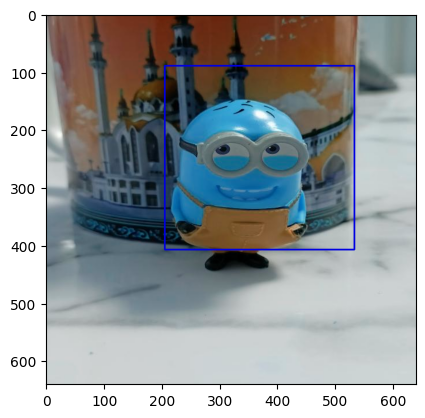

In [67]:
testing_img = cv2.imread(os.path.join(img_path, train_img_path[0]))
x, y, w, h = boxes[16]
cv2.rectangle(testing_img, (x, y), (x + w, y + h), (0, 0, 225), 2)
plt.imshow(testing_img)

In [68]:
boxes

[[219, 238, 214, 123],
 [219, 238, 214, 123],
 [219, 238, 214, 123],
 [219, 238, 214, 123],
 [219, 238, 214, 123],
 [261, 193, 267, 188],
 [216, 213, 208, 138],
 [261, 89, 272, 292],
 [216, 213, 208, 138],
 [228, 89, 305, 318],
 [219, 238, 214, 123],
 [216, 213, 219, 138],
 [228, 89, 305, 318],
 [228, 89, 305, 318],
 [228, 89, 305, 318],
 [216, 89, 317, 318],
 [205, 89, 328, 318],
 [236, 110, 219, 131],
 [236, 110, 219, 131],
 [236, 110, 219, 131],
 [236, 110, 219, 131],
 [236, 110, 219, 131]]